## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [20]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

npr.seed(0)

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

### 2a. Initialize GLM-HMM

In [21]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

### 2b. Specify parameters of generative GLM-HMM

Let's update the weights and transition matrix for the true GLM-HMM so as to bring the GLM-HMM to the parameter regime that real animals use (according to Ashwood et al. (2020)):

In [22]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

Text(0.5, 1.0, 'Generative transition matrix')

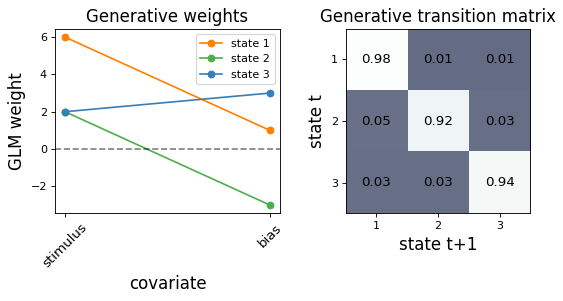

In [23]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

### 2c. Create external input sequences

Simulate an example set of external inputs for each trial in a session. We will create an array of size `(num_sess x num_trials_per_sess x num_covariates)`. As in Ashwood et al. (2020), for each trial in a session we will include the stimulus presented to the animal at that trial, as well as a '1' as the second covariate (so as to capture the animal's innate bias for one of the two options available to it). We will simulate stimuli sequences so as to resemble the sequences of stimuli in the International Brain Laboratory et al. (2020) task.

In [24]:
num_sess = 20 # number of example sessions
num_trials_per_sess = 100 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = [-1, -0.5, -0.25, -0.125, -0.0625, 0, 0.0625, 0.125, 0.25, 0.5, 1]
inpts[:,:,0] = np.random.choice(stim_vals, (num_sess, num_trials_per_sess)) # generate random sequence of stimuli
inpts = list(inpts) #convert inpts to correct format

### 2d. Simulate states and observations with generative model

In [25]:
# Generate a sequence of latents and choices for each session

# True latent is what sate this sample is from
# True choice is what the mouse's choice is

true_latents, true_choices = [], []
for sess in range(num_sess):
    true_z, true_y = true_glmhmm.sample(num_trials_per_sess, input=inpts[sess])
    true_latents.append(true_z)
    true_choices.append(true_y)

In [26]:
# Calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choices, inputs=inpts) 
print("true ll = " + str(true_ll))

true ll = -900.7834782398646


## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [27]:
np.array(true_choices).reshape(20, -1)[0]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
np.array(true_latents)[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
print("num_states = " + str(num_states))
print("obs_dim = " + str(obs_dim))
print("num_categories = " + str(num_categories))
print("input_dim = " + str(input_dim))

print("true_choices.shape = " + str(np.array(true_choices).shape))
print("inpts.shape = " + str(np.array(inpts).shape))

num_states = 3
obs_dim = 1
num_categories = 2
input_dim = 2
true_choices.shape = (20, 100, 1)
inpts.shape = (20, 100, 2)


In [30]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

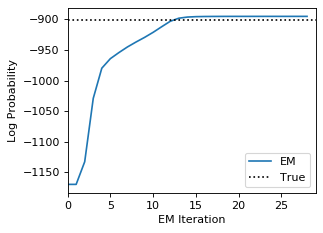

In [31]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we may first need to permute the states of the fit GLM-HMM relative to the
generative model.  One way to do this uses the `find_permutation` function from `ssm`:

In [10]:
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

Now plot generative and retrieved weights for GLMs (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

Text(0.5, 1.0, 'Weight recovery')

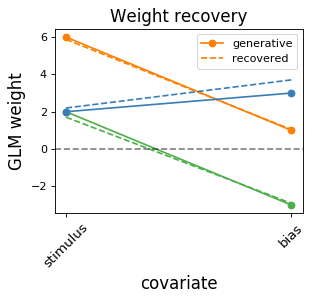

In [11]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], linestyle='-',
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

Now plot generative and retrieved transition matrices (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

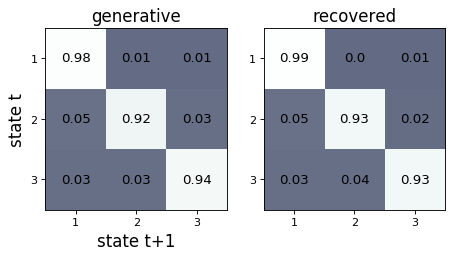

In [12]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### 3c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [13]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choices, inpts)]

Text(0, 0.5, 'p(state)')

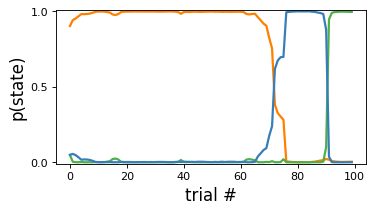

In [14]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [16]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

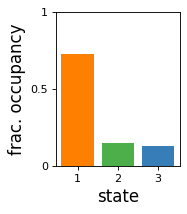

In [18]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)